# Installing Opendatasets

In [2]:
!pip install opendatasets

# Setup and Downloading Dataset

In [ ]:
import opendatasets as od
import random as python_random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
python_random.seed(42)
tf.random.set_seed(42)
od.download_kaggle_dataset('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810&language=Python&outputs=Data', '/content')

Skipping, found downloaded files in "/content/chest-xray-pneumonia" (use force=True to force download)


In [ ]:
BATCH_SIZE = 64
img_size = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation Preparation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_size[0], img_size[1]),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

In [ ]:
def prepare(ds, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Setting Up Data Paths

In [ ]:
# Setting data paths
testPath = '/content/chest-xray-pneumonia/chest_xray/test/'
trainPath = '/content/chest-xray-pneumonia/chest_xray/train/'
visualizationPath = '/content/chest-xray-pneumonia/chest_xray/val/'

# Creating Datasets

In [ ]:
print("Training Dataset:")
training_dataset = keras.utils.image_dataset_from_directory(
  trainPath,
  labels = 'inferred',
  label_mode = 'binary',
  color_mode = 'rgb',
  subset = 'training',
  validation_split = 0.2,
  seed=42,
  shuffle = True,
  batch_size=BATCH_SIZE)

print("Validation Dataset:")
validation_dataset = keras.utils.image_dataset_from_directory(
    trainPath,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    subset = 'validation',
    validation_split = 0.2,
    seed=42,
    shuffle = False,
    batch_size=BATCH_SIZE)

print("Testing Dataset:")
testing_dataset = keras.utils.image_dataset_from_directory(
    testPath,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False,
    batch_size=BATCH_SIZE)

print("Visualization Dataset:")
visualization_dataset = keras.utils.image_dataset_from_directory(
    visualizationPath,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb')

Training Dataset:
Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Validation Dataset:
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Testing Dataset:
Found 624 files belonging to 2 classes.
Visualization Dataset:
Found 16 files belonging to 2 classes.


# Data Visualization

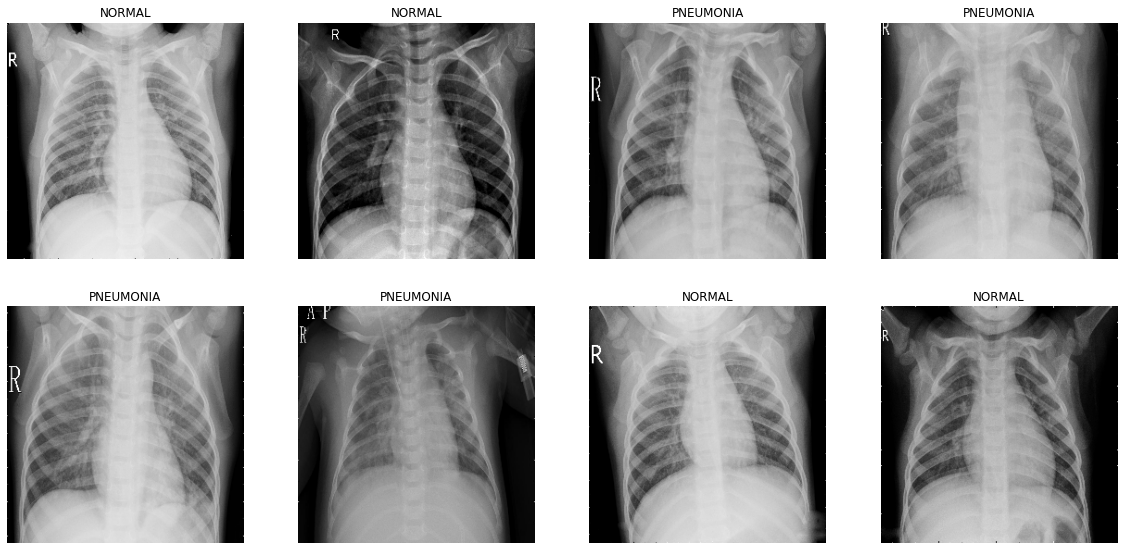

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in visualization_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        classes ={'NORMAL':0 , 'PNEUMONIA':1}
        def ImageClass(n):
          for x , y in classes.items():
            if n == y :
                return x
        plt.title(ImageClass(labels[i]))

# Performing Data Augmentation on the training set and resizing and rescaling images in all datasets

In [ ]:
training_dataset = prepare(training_dataset, augment=True)
validation_dataset = prepare(validation_dataset, augment=False)
testing_dataset = prepare(testing_dataset, augment=False)

# Creating CNN

In [ ]:
cnn = keras.models.Sequential() #initializing

cnn.add(keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", padding = "same", input_shape=[256, 256, 3])) #first convolution
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides = 2)) #first pool

cnn.add(keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu", padding = "same")) #second convolution
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides=2)) #second pool

cnn.add(keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu", padding = "same")) #third convolution
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides = 2)) #third pool

cnn.add(keras.layers.Flatten()) #flattening

cnn.add(keras.layers.Dense(units = 64, activation = 'relu')) #first full connection
keras.layers.Dropout(0.5) #first dropout

cnn.add(keras.layers.Dense(units = 32, activation = 'relu')) #second full connection
keras.layers.Dropout(0.5) #second dropout

cnn.add(keras.layers.Dense(units = 1, activation = "sigmoid"))#Output layer

# Weights to compensate for the unevenness of the dataset

In [ ]:
class_weights = {0: 2.5,
                1: 1.}

# Compiling the CNN and creating callbacks

In [ ]:
cnn.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience = 10, min_delta=0.0001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1, patience=5, min_lr=0.00001)

history = keras.callbacks.History()

# Model Summary

In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)     

# Training the CNN

In [ ]:
cnn.fit(training_dataset, validation_data=validation_dataset, epochs=3000, callbacks=[early_stopping, reduce_lr, history], class_weight=class_weights)

Epoch 1/3000
66/66 [==============================] - 58s 727ms/step - loss: 0.9152 - accuracy: 0.6207 - val_loss: 0.6048 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 2/3000
66/66 [==============================] - 47s 660ms/step - loss: 0.4647 - accuracy: 0.8601 - val_loss: 0.3515 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 3/3000
66/66 [==============================] - 46s 648ms/step - loss: 0.3851 - accuracy: 0.8826 - val_loss: 0.1371 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 4/3000
66/66 [==============================] - 48s 682ms/step - loss: 0.3343 - accuracy: 0.8955 - val_loss: 0.0598 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 5/3000
66/66 [==============================] - 46s 650ms/step - loss: 0.3232 - accuracy: 0.9039 - val_loss: 0.1586 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 6/3000
66/66 [==============================] - 45s 646ms/step - loss: 0.2758 - accuracy: 0.9238 - val_loss: 0.1862 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 7/3000
66/66 [==============================] 

# Training vs Validation Loss Visualization

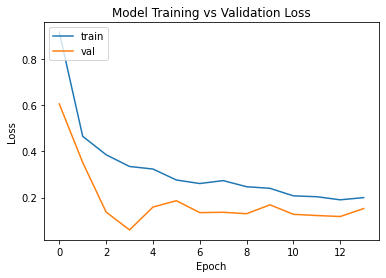

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Training vs Validation Accuracy Visualization

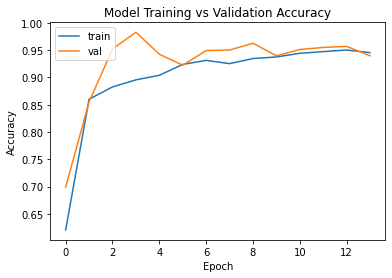

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluating the Model on the Testing Set

In [ ]:
score = cnn.evaluate(testing_dataset, verbose = 0) 

print('Testing loss:', score[0]) 
print('Testing accuracy:', score[1])

Testing loss: 0.2978335916996002
Testing accuracy: 0.8958333134651184
